## はじめに
先日，AWSの東京リージョンで気象庁のサイトがダウンするというインパクトの大きな障害が発生してニュースになりましたが，AWS全体ではどの程度の頻度で障害が発生しているのでしょうか？

本稿ではAWSの障害データから簡単な分析を行い，AWS障害に対する理解を深めてみます。

## AWSの公式障害情報
過去に発生した大規模な障害は[AWSのこちらのサイト](https://aws.amazon.com/premiumsupport/technology/pes/)にレポートが掲載されています。これを読むだけでお腹いっぱいになりそうですが，もう少し全体の傾向が見えるデータを探してみましょう。

AWSがサービスとして提供している[Personal Health Dashboard](https://docs.aws.amazon.com/ja_jp/health/latest/ug/getting-started-phd.html)を覗いてデータを集計できそうです。

...と思ったのですが，ドキュメントをよく読むとPersonal Health Dashboard用のAPI(Health API)を使うにはビジネス以上のサポートプランが必要なようです。お遊び用のアカウントでそこまでの出費はつらい。さらにAPIで取得した情報をQiitaに晒してしまうのはライセンス上問題あるのかもしれません。利用規約はよく読んでませんがとりあえずやめておきましょう。

そこで今度は[Service Health Dashboard](https://status.aws.amazon.com/)を見てみます。このサイトのUIは少々難ありですが，内部で参照しているデータ[https://status.aws.amazon.com/data.json](https://status.aws.amazon.com/data.json)には，2018/5/10からの300件以上の障害データが記録されている様です。これはスバラシイ。今回はこのデータを調べてみます。

## データ収集
データを取得して，過去の障害情報が設定されているarchive属性をDataFrameに変換します。

In [46]:
import pandas as pd
import json
import io
import re
from datetime import datetime, timedelta
import requests
from bs4 import BeautifulSoup, NavigableString
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

response = requests.get("https://status.aws.amazon.com/data.json")
data = response.json()
df = pd.DataFrame.from_records(data["archive"])
df

,service_name,summary,date,status,details,description,service
0,Auto Scaling (N. Virginia),[RESOLVED] Increased API Error Rates,1525914401,1,,"<div><span class=""yellowfg""> 6:06 PM PDT</span...",autoscaling-us-east-1
1,Amazon Elastic Compute Cloud (N. Virginia),[RESOLVED] Delayed network provisioning,1526397141,1,,"<div><span class=""yellowfg""> 8:12 AM PDT</span...",ec2-us-east-1
2,Amazon Elastic Load Balancing (N. Virginia),[RESOLVED] Increased provisioning times,1526397279,1,,"<div><span class=""yellowfg""> 8:14 AM PDT</span...",elb-us-east-1
3,Amazon Elastic MapReduce (N. Virginia),[RESOLVED] Delays in starting clusters,1526397532,1,,"<div><span class=""yellowfg""> 8:19 AM PDT</span...",emr-us-east-1
4,Amazon Simple Storage Service (N. Virginia),[RESOLVED] Elevated error rates,1526466746,1,,"<div><span class=""yellowfg""> 3:32 AM PDT</span...",s3-us-standard
...,...,...,...,...,...,...,...
368,Amazon Elasticsearch Service (N. Virginia),[RESOLVED] Increased Domain Operation Error R...,1614293418,1,,"<div><span class=""yellowfg""> 2:50 PM PST</span...",elasticsearch-us-east-1
369,AWS Transfer for SFTP (N. Virginia),[RESOLVED] Increased Login Failures,1614879450,1,,"<div><span class=""yellowfg""> 9:37 AM PST</span...",transfer-us-east-1
370,AWS CloudFormation (N. Virginia),[RESOLVED] Increased Console Error Rates,1614879598,1,,"<div><span class=""yellowfg""> 9:39 AM PST</span...",cloudformation-us-east-1
371,AWS Internet Connectivity (Sydney),[RESOLVED] Network Connectivity,1615136782,1,,"<div><span class=""yellowfg""> 9:06 AM PST</span...",internetconnectivity-ap-southeast-2


2021/3/17時点では，データの件数は373件で，以下の属性が含まれていました。

- サービス名とリージョン名
- サマリ(障害の現象)
- エポック秒
- 状態
- 詳細(全て空欄)
- 説明(htmlダグで囲まれた障害発生中のレポート)
- サービス名(サービス略称とリージョンコード)

## 前処理
集計し易くするために以下の前処理を実施します。

- サービス名とリージョン名を別なカラムに分離し，サービス名はシンプルに
- エポック秒から，年，月，日を取り出し，別なカラムを追加
- 障害の発生日時と終了日時のカラムを追加(htmlのタグに記載があるが微妙に定型文になっていないので無理矢理抜き出す)
- 障害の発生時間(修復時間)のカラムを追加
- サマリから不要な文字列(ステータスや日本語などの言語)を除去したカラムを追加
- 障害レポートからhtmlタグを除去し少し見易く整形したカラムを追加

In [81]:
def extract_service_name(service_name):
    name = service_name
    region = "Global"
    if (m := re.match(r"([^\(\)]+) \((.+)\)", service_name)) :
        name = m.group(1)
        region = m.group(2)
    name = name.replace("AWS ", "").replace("Amazon ", "")
    return name, region


def extract_time(time_str):
    if (m := re.match(r"(\d{1,2}:\d{2} (?:AM|PM))", time_str)) :
        return m.group(1)
    else:
        return time_str


def extract_failure_start_end(description):
    description = re.sub(r"[\n\t]", "", description)

    # If failures repeated, use the first and last time.
    if (
        len(
            m := re.findall(
                r"(?:B|b)etween (\d{1,2}:\d{2}(?: AM| PM)).*? and (\d{1,2}:\d{2} (?:AM|PM).*? (?:PST|PDT))",
                description,
            )
        )
        > 2
    ):
        return extract_time(m[0][0]), extract_time(m[-1][1]), 1

    # Most cases
    if (
        m := re.match(
            r".*(?:B|b)etween.*? (\d{1,2}:\d{2} ?(?:AM|PM)).*? and.*? (\d{1,2}:\d{2} ?(?:AM|PM) (?:PST|PDT))",
            description,
        )
    ) and re.match(r"\d{1,2}:\d{2}", m.group(1)):
        return extract_time(m.group(1)), extract_time(m.group(2)), 2

    # Others
    start_time = ""
    end_time = ""
    pattern = 3

    if (
        m := re.match(
            r".*(?:Beginning|Starting) at (\d{1,2}:\d{2} ?(?:AM|PM)?) (?:PST|PDT)",
            description,
        )
    ) :
        start_time = m.group(1)
        pattern += 1

    if (m := re.findall(r"(\d{1,2}:\d{2} ?(?:AM|PM))", description)) :
        if not start_time:
            start_time = m[0]

        if m[-1] == start_time and len(m) > 2:
            end_time = m[-2]
            pattern += 1
        else:
            end_time = m[-1]
            pattern += 2

    return extract_time(start_time), extract_time(end_time), pattern


def parse_time(dt, time):
    hm = re.match(r"(\d{1,2}:\d{2})", time).group(1)
    t = datetime.strptime(f"{dt.year}/{dt.month}/{dt.day} {hm}", "%Y/%m/%d %H:%M")
    if t.hour == 12:
        t = t + timedelta(hours=-12)
    if "PM" in time:
        t = t + timedelta(hours=12)
    return t


def extract_failure_time(row):
    dt = row["datetime"]
    start = parse_time(dt, row["start_time"])
    end = parse_time(dt, row["end_time"])
    if end < start:
        # Seems that all incidents were closed within 24 hours.
        # Add one day if end time is smaller than start time.
        end = end + timedelta(days=1)
    delta = end - start
    return delta.total_seconds() / 60


def format_summary(summary):
    summary = re.sub(r"\[.+\] ", "", summary)
    summary = summary.lower()
    summary = re.sub(r"[^\x00-\x7F]", "", summary)
    summary = summary.replace("| ", "")
    summary = summary.strip()
    return summary


def format_description(description):
    bs = BeautifulSoup(description, "html.parser")
    reports = []
    for div in bs.find_all("div"):
        span = div.find("span", {"class": "yellowfg"})
        time_str = span.text
        span.extract()
        report = div.get_text().replace("\n", "")
        reports.append(f"{time_str} - {report}")
    return "\n".join(reports)


def preprocess(df):
    df["datetime"] = pd.to_datetime(df["date"], unit="s")
    df["simple_service_name"], df["region_name"] = zip(
        *df["service_name"].map(extract_service_name)
    )
    df["start_time"], df["end_time"], df["pattern_for_debug"] = zip(
        *df["description"].map(extract_failure_start_end)
    )
    df["timezone"] = df["description"].map(
        lambda description: "PST" if " PST" in description else "PDT"
    )
    df["failure_time"] = df.apply(extract_failure_time, axis=1)
    df["year"] = df["datetime"].dt.year
    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["iso_date"] = df["datetime"].dt.strftime("%Y-%m-%d")
    df["problem"] = df["summary"].map(format_summary)
    df["report"] = df["description"].map(format_description)
    return df


df = preprocess(df)
df.to_csv("dataframe.csv")
df

,service_name,summary,date,status,details,description,service,datetime,simple_service_name,region_name,...,end_time,pattern_for_debug,timezone,failure_time,year,month,day,iso_date,problem,report
0,Auto Scaling (N. Virginia),[RESOLVED] Increased API Error Rates,1525914401,1,,"<div><span class=""yellowfg""> 6:06 PM PDT</span...",autoscaling-us-east-1,2018-05-10 01:06:41,Auto Scaling,N. Virginia,...,7:04 PM,2,PDT,82.0,2018,5,10,2018-05-10,increased api error rates,6:06 PM PDT - We are investigating increased...
1,Amazon Elastic Compute Cloud (N. Virginia),[RESOLVED] Delayed network provisioning,1526397141,1,,"<div><span class=""yellowfg""> 8:12 AM PDT</span...",ec2-us-east-1,2018-05-15 15:12:21,Elastic Compute Cloud,N. Virginia,...,8:17 AM,2,PDT,170.0,2018,5,15,2018-05-15,delayed network provisioning,8:12 AM PDT - We are investigating delayed n...
2,Amazon Elastic Load Balancing (N. Virginia),[RESOLVED] Increased provisioning times,1526397279,1,,"<div><span class=""yellowfg""> 8:14 AM PDT</span...",elb-us-east-1,2018-05-15 15:14:39,Elastic Load Balancing,N. Virginia,...,8:17 AM,2,PDT,132.0,2018,5,15,2018-05-15,increased provisioning times,8:14 AM PDT - We are investigating increased...
3,Amazon Elastic MapReduce (N. Virginia),[RESOLVED] Delays in starting clusters,1526397532,1,,"<div><span class=""yellowfg""> 8:19 AM PDT</span...",emr-us-east-1,2018-05-15 15:18:52,Elastic MapReduce,N. Virginia,...,8:15 AM,2,PDT,75.0,2018,5,15,2018-05-15,delays in starting clusters,8:19 AM PDT - We are investigating delays in...
4,Amazon Simple Storage Service (N. Virginia),[RESOLVED] Elevated error rates,1526466746,1,,"<div><span class=""yellowfg""> 3:32 AM PDT</span...",s3-us-standard,2018-05-16 10:32:26,Simple Storage Service,N. Virginia,...,2:39 AM,2,PDT,4.0,2018,5,16,2018-05-16,elevated error rates,3:32 AM PDT - Between 2:35 AM and 2:39 AM PD...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Amazon Elasticsearch Service (N. Virginia),[RESOLVED] Increased Domain Operation Error R...,1614293418,1,,"<div><span class=""yellowfg""> 2:50 PM PST</span...",elasticsearch-us-east-1,2021-02-25 22:50:18,Elasticsearch Service,N. Virginia,...,5:15 PM,6,PST,789.0,2021,2,25,2021-02-25,increased domain operation error rates,2:50 PM PST - Beginning at 4:06 AM PST we be...
369,AWS Transfer for SFTP (N. Virginia),[RESOLVED] Increased Login Failures,1614879450,1,,"<div><span class=""yellowfg""> 9:37 AM PST</span...",transfer-us-east-1,2021-03-04 17:37:30,Transfer for SFTP,N. Virginia,...,6:39 AM,2,PST,185.0,2021,3,4,2021-03-04,increased login failures,9:37 AM PST - Between 3:34 AM and 6:39 AM PS...
370,AWS CloudFormation (N. Virginia),[RESOLVED] Increased Console Error Rates,1614879598,1,,"<div><span class=""yellowfg""> 9:39 AM PST</span...",cloudformation-us-east-1,2021-03-04 17:39:58,CloudFormation,N. Virginia,...,9:52 AM,2,PST,38.0,2021,3,4,2021-03-04,increased console error rates,9:39 AM PST - We are investigating increased...
371,AWS Internet Connectivity (Sydney),[RESOLVED] Network Connectivity,1615136782,1,,"<div><span class=""yellowfg""> 9:06 AM PST</span...",internetconnectivity-ap-southeast-2,2021-03-07 17:06:22,Internet Connectivity,Sydney,...,10:59 AM,2,PST,160.0,2021,3,7,2021-03-07,network connectivity,9:06 AM PST - We are investigating an issue ...


若干怪しいところはありますが，なんとか欲しい値は取り出せた気がします。

## 障害報告の件数
この障害データのJSON配列の件数は373件ですが，サービスごとに1件の報告が作成されています。
データセンター障害などで複数のサービスに同時に障害が発生する場合はまとめて1件としてもよさそうです。
そこで，同一リージョンに同一日に発生した障害は1件として集計してみます。

In [35]:
df_groupby_region_date = df.groupby(["region_name", "iso_date"]).size().reset_index()
df_groupby_region_date

,region_name,iso_date,0
0,Frankfurt,2018-07-19,1
1,Frankfurt,2018-08-08,1
2,Frankfurt,2018-10-01,1
3,Frankfurt,2019-10-08,1
4,Frankfurt,2019-10-09,1
...,...,...,...
260,US-East,2020-07-15,1
261,US-West,2018-12-11,1
262,US-West,2019-11-07,1
263,US-West,2020-02-13,1


全体で265件になりました。

## リージョンごとの障害件数
リージョンごとの障害件数は以下の通りです。

In [36]:
df_countby_date = (
    df_groupby_region_date
    .groupby(["region_name"])
    .size()
    .to_frame("size")
    .sort_values("size", ascending=False)
    .reset_index()
)
df_countby_date["ratio"] = (df_countby_date["size"]/df_countby_date["size"].sum())
df_countby_date.to_csv("countby_date.csv", index=False)
df_countby_date

,region_name,size,ratio
0,N. Virginia,94,0.354717
1,Global,56,0.211321
2,Oregon,22,0.083019
3,Ireland,17,0.064151
4,Sydney,9,0.033962
5,Sao Paulo,9,0.033962
6,Tokyo,8,0.030189
7,Frankfurt,7,0.026415
8,Ohio,6,0.022642
9,N. California,6,0.022642


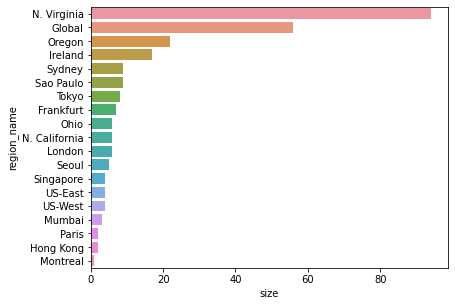

In [92]:
sns.barplot(x=df_countby_date["size"], y=df_countby_date["region_name"])
plt.savefig('countby_date.png', dpi=300, bbox_inches='tight')
plt.show()

- Virginiaが群を抜いています。提供されているサービスが最も多く，AWSの中核となるリージョンなので障害も多いのでしょう
- GlobalなサービスのRoute53,CloudFront,IAMでもかなりの障害が発生しています
- Oregon，Irelandがそれらに続き，その他のリージョンの障害は約3年間で一桁台です
- GovCloud(US-WEST,US-EAST)でも他リージョンと同様に障害が発生しています。政府系なのでやはり日本と同様に障害を起こすとめちゃくちゃ怒られるのでしょうか。余計な心配をしてしまいます

## サービスごとの障害件数
サービスごとの障害件数は以下の通りです(母数は373件)。

In [91]:
df_countby_service = (
    df.groupby(["simple_service_name"])
    .size()
    .to_frame("size")
    .reset_index()
    .sort_values("size", ascending=False)
    .reset_index(drop=True)
)
df_countby_service["ratio"] = (df_countby_service["size"]/df_countby_service["size"].sum())
df_countby_service.to_csv("countby_service.csv", index=False)
df_countby_service

,simple_service_name,size,ratio
0,Elastic Compute Cloud,63,0.168901
1,CloudFront,17,0.045576
2,Relational Database Service,17,0.045576
3,CloudWatch,15,0.040214
4,Elastic Load Balancing,14,0.037534
...,...,...,...
71,MQ,1,0.002681
72,NAT Gateway,1,0.002681
73,Organizations,1,0.002681
74,Personalize,1,0.002681


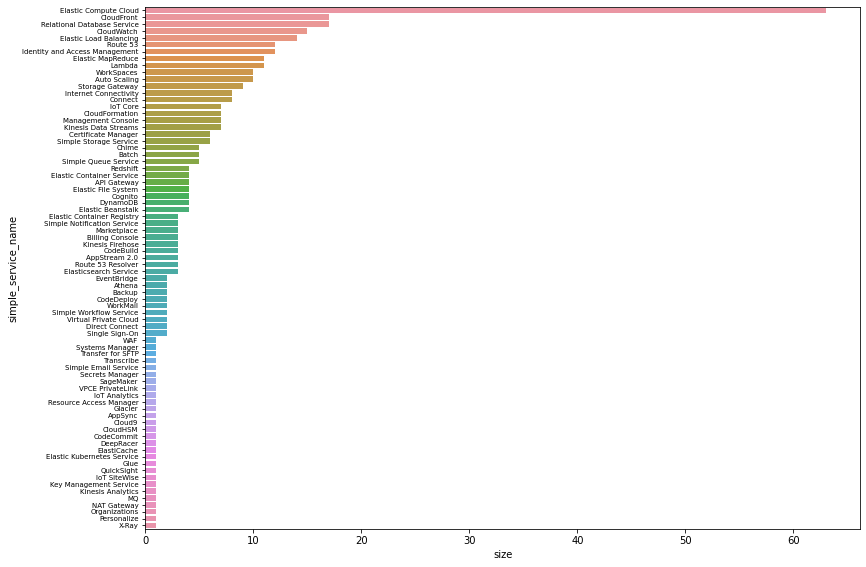

In [93]:
plt.rc("ytick", labelsize=7)
plt.rcParams["figure.figsize"] = (12.8,9.6)
sns.barplot(x=df_countby_service["size"], y=df_countby_service["simple_service_name"])
plt.savefig('countby_service.png', dpi=300, bbox_inches='tight')
plt.show()

- EC2とRDSの障害が多く，これらの合計が全体の20%強となっています
- 残りはその他70以上のサービスですが，グローバル又はサーバレスのものが多数含まれています

## 大規模(複数サービス)障害
残念ながら今回の障害データには具体的な障害の規模は記載されていません。

できれば大規模な障害がどの程度の頻度で発生しているかも調べてみたいですが，どうしましょう。

上記で同一日に複数サービスから障害が報告されている場合の件数をまとめて集計しましたが，このようなケースは大規模な障害によって広範囲に影響が出ていると考えられます。

そこで，同一日に複数のサービスで障害発生しているケースを集計してみます。
ついでに以下のカラムも追加してみます。
- 同一日に障害が発生したサービス数とそのサービス名
- 同一日に障害が発生したサービスの障害の時間(修復時間)(分)

In [38]:
df_agg = (
    df.groupby(["region_name", "iso_date"])
    .agg({"simple_service_name": ["count", ", ".join], "failure_time": ["mean"]})
    .reset_index()
)
df_agg.columns = [
    "region_name",
    "date",
    "count",
    "services",
    "mean_failure_time(min)",
]
df_large_scale_failure = df_agg[df_agg["count"] > 1].reset_index(drop=True)
df_large_scale_failure.to_csv("large_scale_failures.csv", index=False)
df_large_scale_failure

,region_name,date,count,services,mean_failure_time(min)
0,Frankfurt,2019-11-12,4,"Elastic Compute Cloud, Relational Database Ser...",213.000000
1,Global,2019-10-20,2,"Route 53, Route 53",125.000000
2,Global,2020-06-12,2,"Identity and Access Management, Organizations",501.500000
3,Global,2020-10-01,2,"CloudFront, Identity and Access Management",65.000000
4,Hong Kong,2019-11-07,3,"Kinesis Data Streams, CloudWatch, Kinesis Fire...",94.000000
5,Ireland,2018-09-26,4,"Elastic Compute Cloud, CloudHSM, Elastic File ...",78.500000
6,Ireland,2019-05-10,2,"Elastic Beanstalk, Relational Database Service",114.000000
7,Ireland,2019-10-02,3,"Batch, IoT Core, API Gateway",105.666667
8,London,2019-01-12,3,"Elastic Compute Cloud, Lambda, Relational Data...",96.666667
9,London,2019-06-30,4,"Elastic Compute Cloud, Elastic Load Balancing,...",97.000000


こうすると，複数サービスに波及していると想定される障害が45件抽出できました。

これらの全てが大規模というほどではないかもしれませんが，とりあえず東京は最近大きなニュースになったものが残りました。
やはりVirginiaがダントツで多いです。

## 年ごとの障害件数
今度は年ごとの障害件数も集計してみましょう。単純な件数の他に，先ほど集計した大規模障害の件数も加えてみます。

In [95]:
df_groupby_date = (
    df.groupby(["region_name", "year", "month", "day"])
    .size()
    .to_frame("size")
    .reset_index()
)
df_failure_count = df_groupby_date.groupby("year").size().to_frame("size").reset_index()
df_failure_count.columns = ["year", "failure_count"]
df_lsf = df_groupby_date[df_groupby_date["size"] > 1]
df_lsf_count = (
    df_lsf.groupby("year").size().to_frame("size").reset_index().sort_values("year")
)
df_lsf_count.columns = ["year", "large_scale_failure_count"]
df_countby_year = pd.merge(df_failure_count, df_lsf_count)
df_countby_year["large_scale_ratio"] = (
    df_countby_year["large_scale_failure_count"] / df_countby_year["failure_count"]
)
df_countby_year.to_csv("countby_year.csv", index=False)
df_countby_year

,year,failure_count,large_scale_failure_count,large_scale_ratio
0,2018,68,11,0.161765
1,2019,90,18,0.200000
2,2020,92,14,0.152174
3,2021,15,3,0.200000


通年でデータが取れているのは2019年と2020年のみなので，毎年の傾向とまでは言い切れないですが，とりあえず手元の数字では以下の様になっている様です。

- AWS全体では年間90件前後の障害が発生している
- 毎年15件前後(障害全体の20%前後)で複数サービスに影響が出る大規模な障害が発生している

AWSの保有するサーバ数や利用するユーザー数は近年明確に公表されていない様ですが，AWSの収益は年30％前後成長と言われており，サービスの基盤も同程度で拡大していると想定されます。その様なペースで成長し続けているにも関わらず，毎年障害の件数を一定に保てているのは非常に優秀な運用設計がなされていると考えてもよいと思います

## 障害の発生時間(修復時間)
せっかく障害の発生時間を抽出したので，平均値(MTTR)などもみておきましょう。大規模障害のものと並べてみます。ちなみに障害レポートが中途半端で発生日時と終了日時が取得できない物が何件かありましたがそれらは除きます。

In [41]:
df_failure_time = df[df["failure_time"] > 0]["failure_time"].describe()
df_lsf_time = df_large_scale_failure["mean_failure_time(min)"].describe()
df_failure_time = pd.concat([df_failure_time, df_lsf_time], axis=1)
df_failure_time.columns = ["failure_time_stats(min)", "learge_scale_failure_time_stats(min)"]
df_failure_time.to_csv("describe_failure_time.csv")
df_failure_time

,failure_time_stats(min),learge_scale_failure_time_stats(min)
count,370.000000,46.000000
mean,210.254054,191.121391
std,228.727398,170.699999
min,1.000000,19.000000
25%,71.250000,94.666667
50%,129.500000,127.000000
75%,242.500000,212.416667
max,1354.000000,924.636364


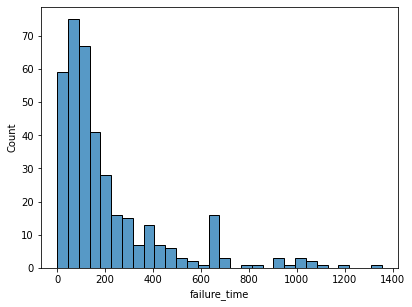

In [94]:
plt.rc("ytick", labelsize=10)
plt.rcParams["figure.figsize"] = (6.4,4.8)
sns.histplot(df, x="failure_time", bins=30)
plt.savefig('failure_time_hist.png', dpi=300, bbox_inches='tight')
plt.show()

- 障害の発生時間(修復時間)の平均(MTTR)は約210分で，大半は200分以内に復旧している模様
- 最大で20時間以上障害が継続したケースあり。大規模障害の場合でも最大で15時間程度継続したことがある模様

## 障害の内容
サマリのカラムがあるので試しに障害の内容もざっくり分類してみます。

In [99]:
df_problem = (
    df.groupby(["simple_service_name", "problem"]).size().to_frame("size").reset_index()
)
df_problem.to_csv("problem.csv", index=False)
df_problem

df_problem = df.groupby(["problem"]).size().to_frame("size").reset_index()
df_problem.to_csv("problems.csv", index=False)
df_problem

,problem,size
0,additional information,1
1,alarm delays,1
2,api error rate,1
3,api error rates and latencies,1
4,api error rates and metric delays,1
...,...,...
170,traffic impacted for nat gateways,1
171,traffic impacted for network load balancer,1
172,traffic impacted for vpc endpoints,1
173,validation and issuance delays for new certifi...,1


175種類も出てしまいました。

API等のエラー，ネットワーク接続エラー，処理の遅延，等が大半の様ですが，似て非なる文字列が大量にあってなかなか丸めるのが大変なので今回は諦めます...

## まとめ
本稿ではAWSが公開している障害のデータを覗いてみました。世界のリージョンでは多くの障害が発生しており，それがいつ東京や大阪で起こってもおかしくないことを実感しました。

本稿で扱ったAWSの公式情報以外にも，障害の解説や対策等を記載してくださっている方が多くいらっしゃいます。そういった情報によく目を通し，いざという時のAWS障害に備えておきましょう。